# Before reading
This kernel is a Korean translation of [the kernel written by Bert Carremans](https://www.kaggle.com/bertcarremans/data-preparation-exploration/notebook).  
이 커널은 [Bert Carremans이 작성한 커널](https://www.kaggle.com/bertcarremans/data-preparation-exploration/notebook)을 한국어로 번역한 것입니다.


## Introduction

이 노트북은 PorteSeguro competition을 위한 데이터 분석을 목표로 잡고 있습니다. 이를 통해, 데이터 모델링을 하는데 여러 팁과 트릭들을 얻어갈 수 있을 것입니다. 이 노트북은 다음과 같은 섹션들로 이루어집니다.

1. [Visual inspection of your data](#visual_inspection)
2. [Defining the metadata](#metadata)
3. [Descriptive statistics](#descriptive_stats)
4. [Handling imbalanced classes](#imbalanced_data)
5. [Data quality checks](#data_quality)
6. [Exploratory data visualization](#eda)
7. [Feature engineering](#feat_engineering)
8. [Feature selection](#feat_selection)
9. [Feature scaling](#feat_scaling)

## Loading packages

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100) # columns 최대 출력 속성 변경

## Loading data

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

<a class="anchor" id="visual_inspection"></a>

## Data at first sight

Competition 에서 주어진 데이터 설명을 보겠습니다.

* 유사한 속성을 가진 feature들은 ind, reg, car, calc 같은 이름들로 지어졌습니다.
* feature 이름들 뒤에 붙은 **'bin'**은 binary features를 **'cat'**은 category features를 나타냅니다.
* 뒤에 무언가 붙지 않은 feature들은 **continuous** 하거나 **ordinal**한 데이터를 나타냅니다.
* **-1** 값은 **missing** 값을 나타냅니다.
* **Target** 속성 값은 이전에 claim(청구)이 있었는가, 없었는가 여부를 나타냅니다.

이러한 설명들은 시작할 때 매우 중요한 정보입니다. 이제, 데이터의 첫 부분과 마지막 부분을 빠르게 살펴보겠습니다.

In [6]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [7]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


다음과 같은 것들을 볼 수 있습니다.
* binary variables
* 정수 값으로 이루어지는 categorical variables
* 정수 또는 실수로 이루어져 있는 다른 variables
* missing 값인 -1이 있는 variables
* target variables과 ID variable

이제 train data의 열과 행의 수를 봅시다.

In [8]:
train.shape

(595212, 59)

데이터는 59개 variables와 595,212 rows로 이루어져있습니다. test 데이터도 같은 수의 variables를 가지는지 보도록 하겠습니다.  
그리고 training data에 중복되는 row는 없는지 보도록 하죠.

In [9]:
train.drop_duplicates()
train.shape

(595212, 59)

중복되는 열은 없네요. 좋습니다.

In [10]:
test.shape

(892816, 58)

test set에는 1개의 variable이 모자라는 것을 볼 수 있습니다. 하지만 그건 target variable이므로, 괜찮습니다.  
이제 이러한 variables들이 어떤 타입을 가지는지 조사해보도록 하죠.

그리고 나서 14 categorical variables들을 처리하기 위한 dummy variables를 만들도록 하겠습니다.  
bin variables는 이미 binary 데이터이므로 dummy화를 진행하지 않겠습니다.

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

다시, info() 메서드를 통해 데이터 타입이 정수형 또는 실수형인 것을 알 수 있습니다.  
Missing value는 -1로 대체되어 있기 때문에 null value가 없다는 것도 알 수 있습니다.

<a class="anchor" id="metadata"></a>

## Metadata
데이터 관리를 용이하게 하기 위해서, variable들에 대한 meta-information을 DataFrame을 이용하여 저장해놓도록 하겠습니다. 이렇게 구성하는 것은 분석, 시각화, 모델링 등에서 특정한 variable를 선택하기 원할 때 매우 도움이 됩니다.  
  
구체적으로 다음과 같이 구성됩니다:
- **role**: input, ID, target
- **level**: nominal, interval, ordinal, binary
- **keep**: True or False
- **dtype**: int, float, str

In [0]:
data = []
for f in train.columns:
    # role 정의
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # level 정의
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    # id를 제외한 모든 variables에 대해 keep을 True로 초기화
    keep = True
    if f == 'id':
        keep = False
    
    # data type 정의
    dtype = train[f].dtype
    
    # variable들에 대한 모든 metadata를 포함하고 있는 Dict 생성
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [13]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


예를 들어, 사용하는 모든 nomial variables들을 추출해보면

In [14]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

각 role과 level에 대한 variable들의 수를 출력해보도록 하겠습니다. 
pandas의 groupby를 활용하여 meta DataFrame에 대해 role, level로 묶어서 그 수를 구합니다. groupby만으로 출력을 하면 일반 값들로 나오게 되는데, 이를 다시 DataFrame화 하여 출력합니다.

In [15]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


<a class="anchor" id="descriptive_stats"></a>

## Descriptive statistics

우리는 또 dataframe의 describe 메서드를 활용할 수도 있습니다. 하지만, categorical variables와 id variable에서 평균, 표준편차 등을 계산하는 것은 필요하지 않습니다. categorical variables에 대해서는 후에 시각화로 데이터 분석을 진행할 것입니다.  
  
meta dataframe 덕분에, 우리는 쉽게 원하는 variable들을 선택할 수 있고, 기술 통계를 계산할 수 있습니다. 명확히 보여주기 위해, 데이터 타입마다 진행하였습니다.

### Interval variables

In [16]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


#### reg variables
- 오직 ps_reg_03만 missing values를 가집니다.
- 최저값과 최고값의 범위가 variable마다 다릅니다. 여기에 scaling(e.g. StandardScaler)을 적용할 수 있습니다.

#### car variables
- ps_car_12와 ps_car_15는 missing values를 가집니다.
- 앞선 reg variables와 마찬가지로, 최저값과 최고값의 범위가 다 다르며, scaling을 적용할 수 있습니다.

#### calc variables
- missing values가 없습니다.
- 최고값이 0.9 인 규칙이 있는 것으로 보입니다.
- 3개의 *_calc* variables는 매우 유사한 분포를 가집니다.


**전체적으로**, interval variables의 range가 다소 좁은 것을 알 수 있었습니다. 아마도, 데이터의 익명성을 위해 약간의 변형(e.g. log)이 적용된 것으로 보입니다.


### Ordinal variables

In [17]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- 오직 ps_car_11 variable 만이 missing variable을 가집니다.
- 여기서도 마찬가지로, 각 feature 간에 다른 데이터 범위를 가지기 때문에 scaling을 적용해야할 것입니다.

### Binary variables

In [18]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- target 평균이 0.036448 인 것을 보아, 데이터의 label이 매우 심하게 불균형하다고 볼 수 있습니다.
- 대부분의 variables의 값이 0으로 이루어져있음을 알 수 있습니다.

## Handling imbalanced classes
위에서 언급했듯, target=1 인 데이터는 target=0인 데이터에 비해 매우 적습니다. 이는 높은 정확률을 가져올 수 있으나, 실전에서는 사용할 수 없습니다.
이 문제를 다루기 위한 방법은 2가지가 있습니다.
* traget=1 records를 oversampling 하기
* target=0 records를 undersampling 하기

사실, 여기에는 더 많은 방법들이 존재합니다. 여러 방법들에 대해 더 알고싶다면, [MachineLearningMastery.com]((https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)를 참조하십시요.  

현재 우리가 다소 큰 training set을 가지고 있으므로, **undersampling**을 이용해보도록 하겠습니다.

In [19]:
desired_apriori=0.10

# target 값에 따른 인덱스 가져오기
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# target 값에 따른 기존 records 수 가져오기
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# undersampling 비율 계산
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
# undersmapling 하고 난 후의 target=0 records 수
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# target=0 records 인덱스 중에서 undersample 비율만큼 랜덤 선택
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# 사용할 index list (기존 target=1 records indices + undersampling target=0 records indices)
idx_list = list(undersampled_idx) + list(idx_1)

# undersample dataframe
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


<a class="anchor" id="data_quality"></a>

## Data Quality Checks

### Missing values 확인하기
Missing 값들은 -1로 표기되었습니다.

In [20]:
vars_with_missing = []

for f in train.columns:
    # column들을 돌아가면서 값이 -1인 index를 사용해 missing 개수 계산
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        
        # missing value 비율
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


- **ps_car_03_cat**(68%)와 **ps_car_05_cat**(44%)은 missing value가 많은 부분을 차지합니다. 고로, 이 variables은 삭제합니다.
- 이를 제외한 다른 categorical variable들은 missing value 비율이 크지 않으므로, 남겨두겠습니다.
- **ps_reg_03** (continuous)는 전체 records의 18%가 missing value로 이루어져 있습니다. 이는 mean으로 대체합니다.
- **ps_car_11** (continuous)는 오직 1개의 records만 missing value를 가지고 있습니다. 이는 mean으로 대체합니다.
- **ps_car_14** (continuous)는 전체 records의 7%가 mssing value로 이루어져 있습니다. 이는 mean으로 대체합니다.

In [0]:
# 너무 많은 missing value를 가지는 variables를 삭제
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop),'keep'] = False  # meta 정보 업데이트

# missing value를 mean 또는 mode로 대체
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mean_imp.fit_transform(train[['ps_car_11']]).ravel()

### categorical variables의 cardinality 확인하기
Cardinality는 variable 안에서 다른 values의 수를 표현합니다. 후에 categorical variables에 대해 dummy variables를 만들기 위해서 먼저 variable들이 많은 별개의 values로 이루어져 있는지 확인할 필요가 있습니다. 특정한 경우 너무 많은 dummy variable들이 만들어질 수 있기 때문에, variable들의 상황을 보아가며 여러 방법으로 다뤄주어야 합니다.


In [0]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


**ps_car_11_cat**만이 많은 각기 다른 values를 가진다는 것을 알 수 있습니다.  

이것을 처리하기 앞서, 기존 처리코드에 문제가 있음을 [nickycan](https://www.kaggle.com/nickycan)님이 지적해주셨습니다. 그래서 기존코드 대신 [nickycan](https://www.kaggle.com/nickycan)님이 만든 kernel에서 사용한 방법을 사용하여 처리하도록 하겠습니다.
* 구현 원리는 docstring에 명시되어 있듯 [Daniele Micci-Barreca이 작성한 논문](https://dl.acm.org/doi/10.1145/507533.507538)을 참고하였습니다.


In [0]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [0]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

<a class="anchor" id="eda"></a>

## Exploratory Data Visualization

### Categorical variables
이제 categorical variables을 시각화 해봅시다. 먼저, target=1인 고객들의 비율을 시각화 해보겠습니다.

<Figure size 432x288 with 0 Axes>

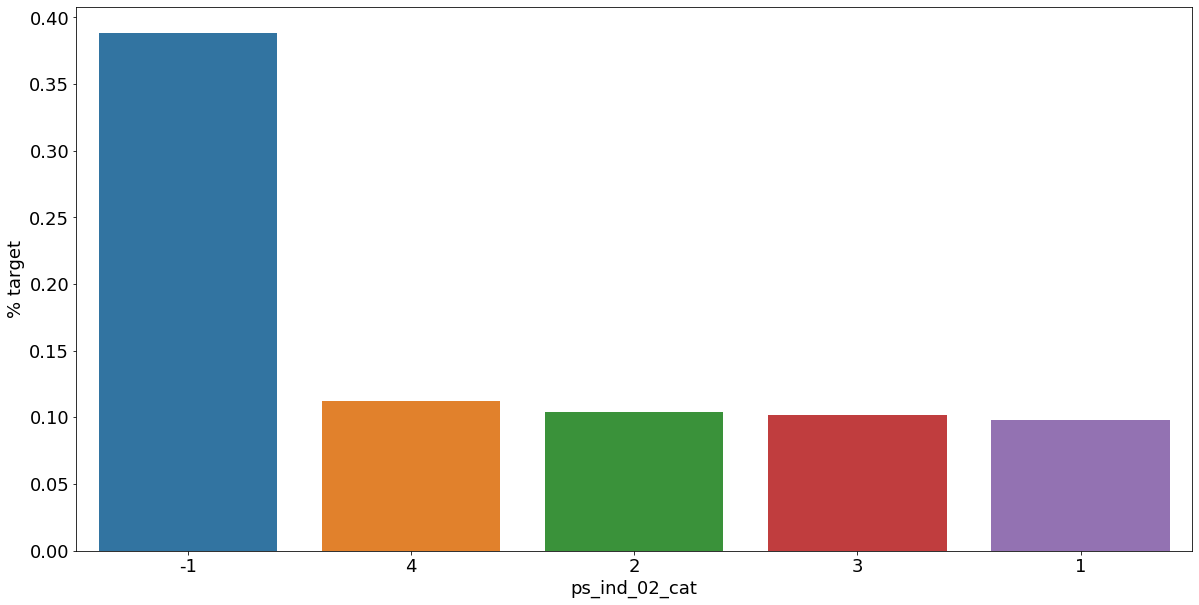

<Figure size 432x288 with 0 Axes>

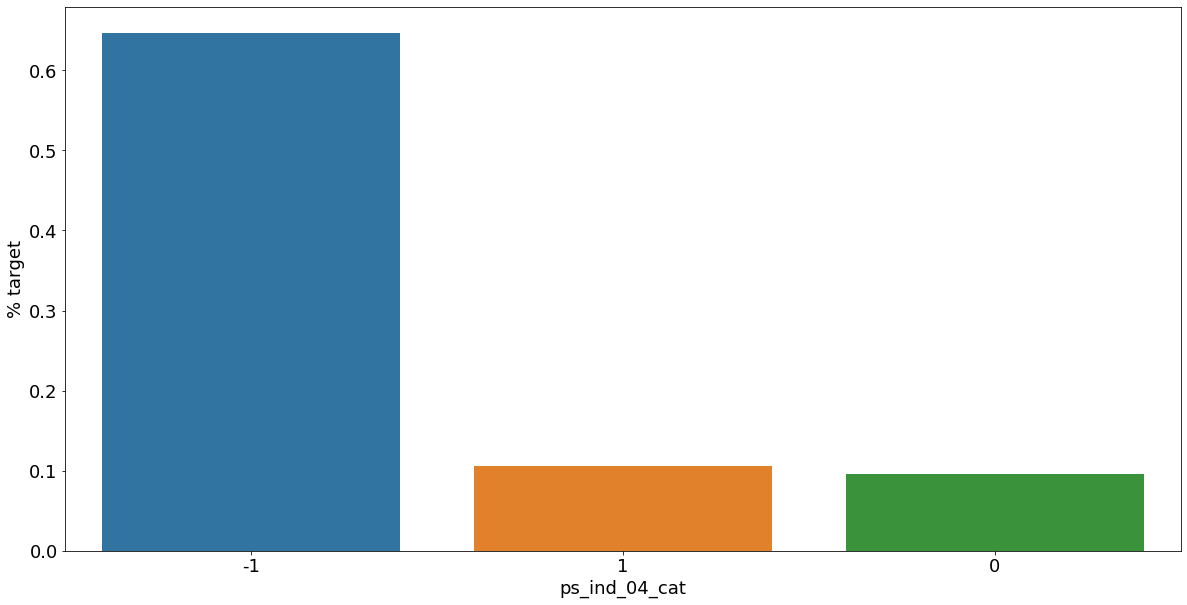

<Figure size 432x288 with 0 Axes>

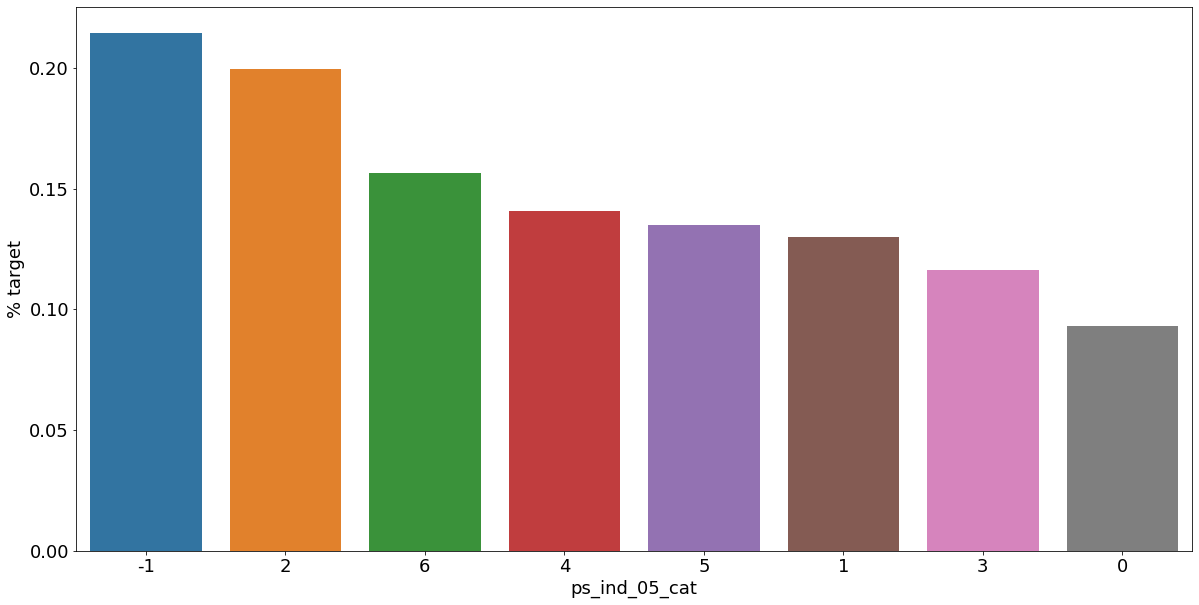

<Figure size 432x288 with 0 Axes>

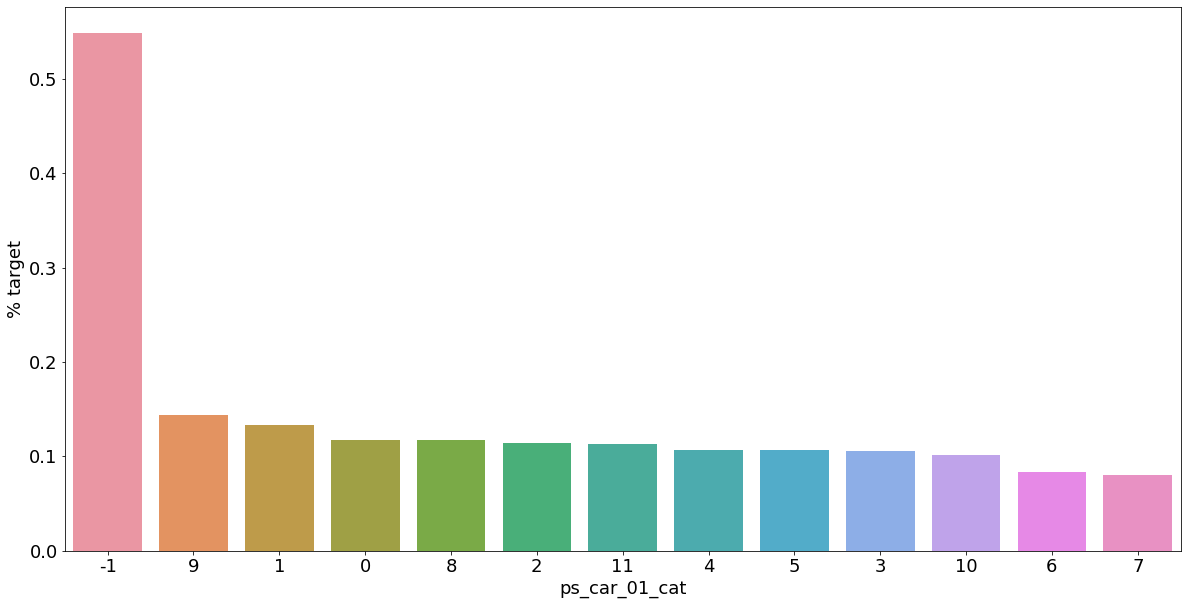

<Figure size 432x288 with 0 Axes>

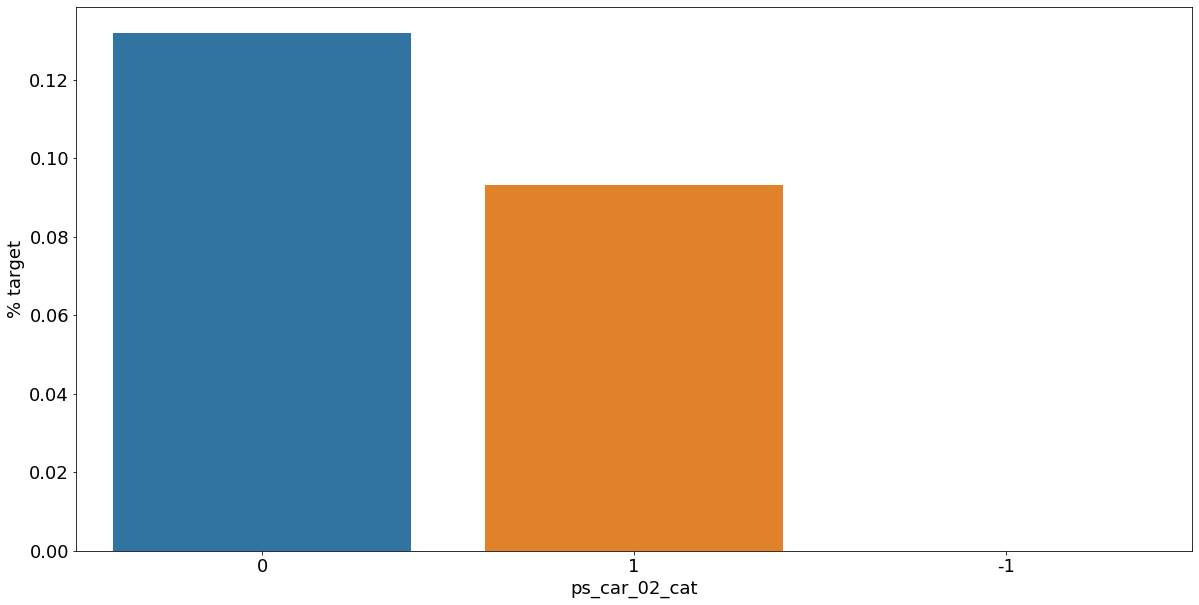

<Figure size 432x288 with 0 Axes>

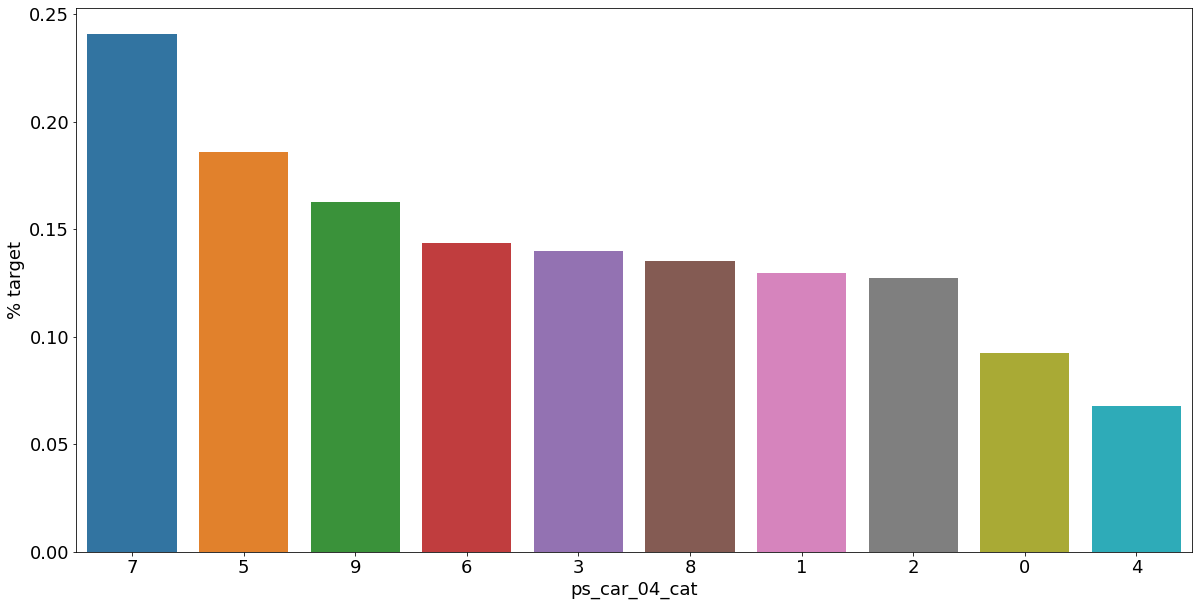

<Figure size 432x288 with 0 Axes>

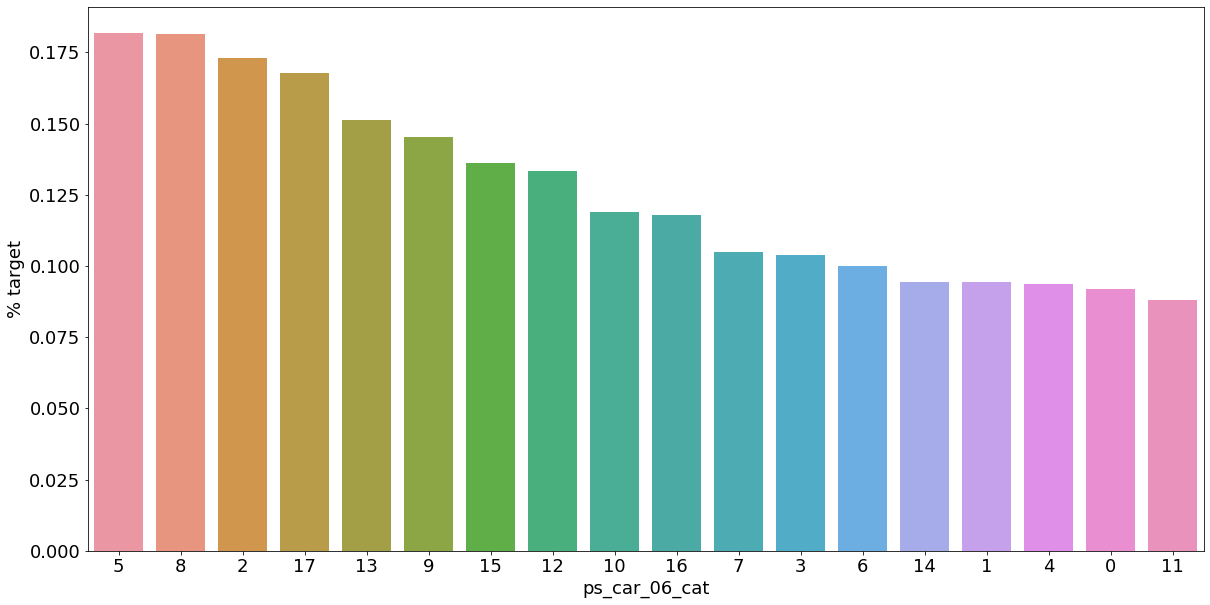

<Figure size 432x288 with 0 Axes>

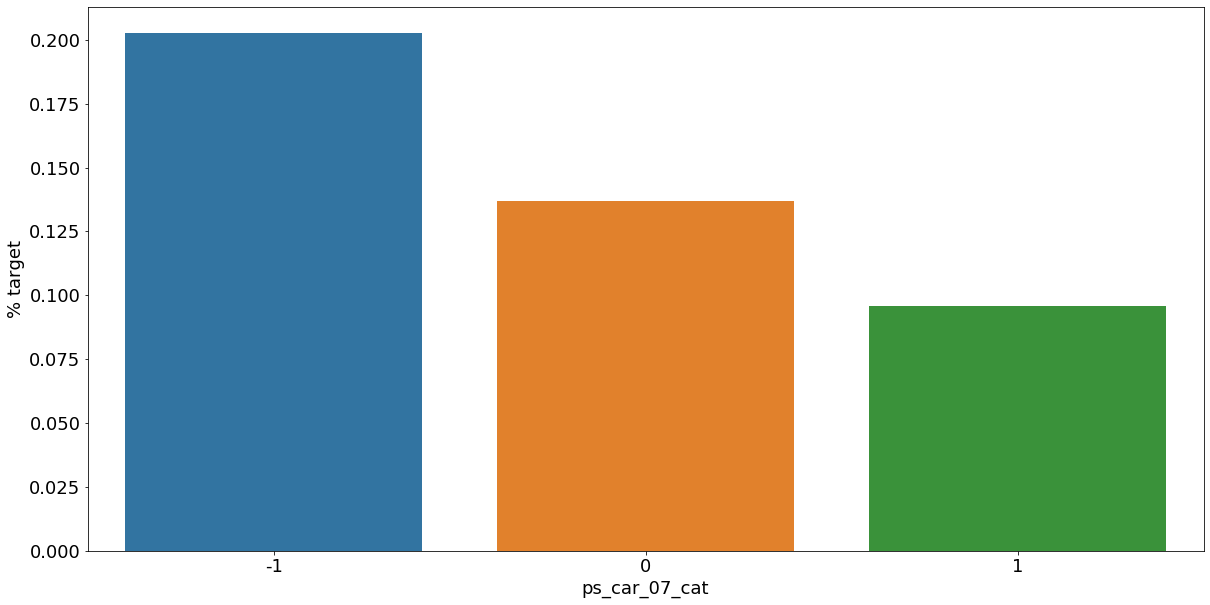

<Figure size 432x288 with 0 Axes>

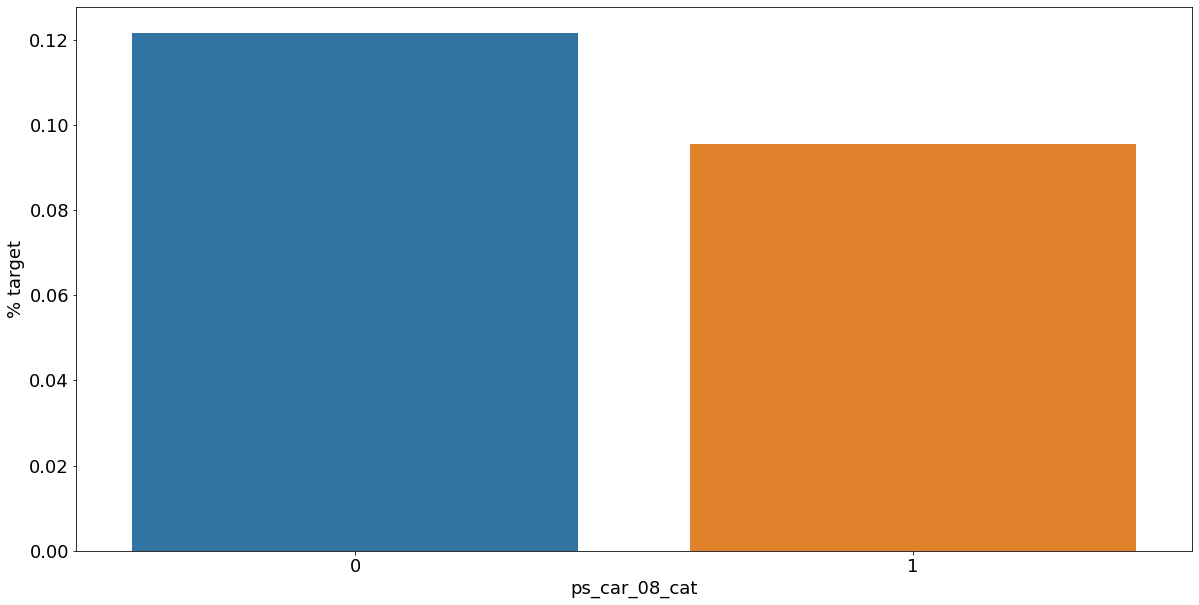

<Figure size 432x288 with 0 Axes>

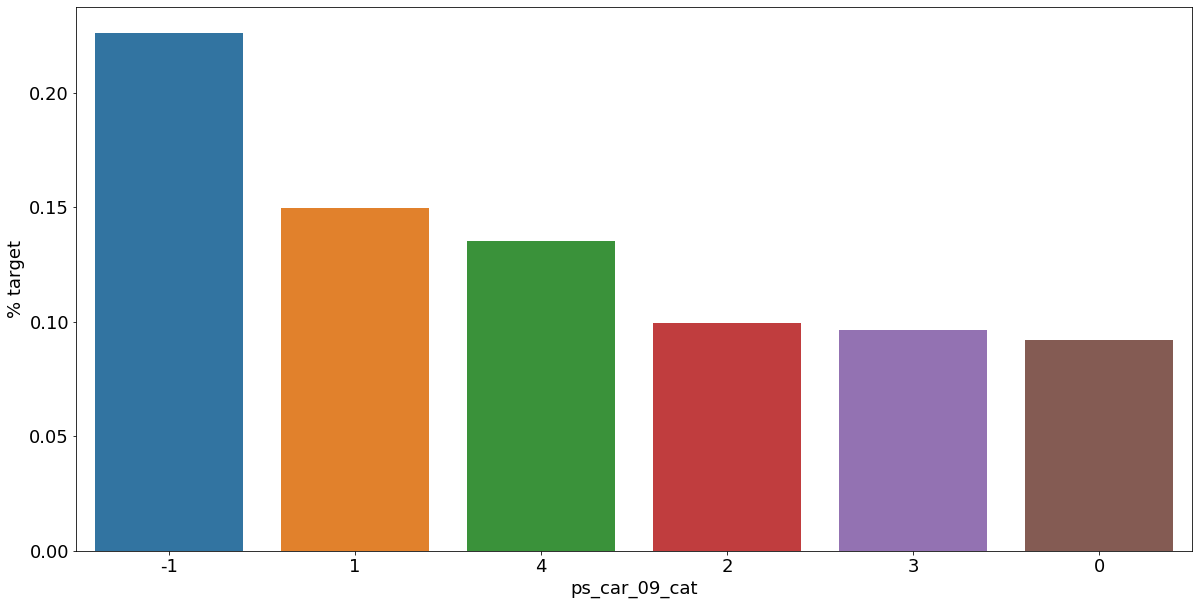

<Figure size 432x288 with 0 Axes>

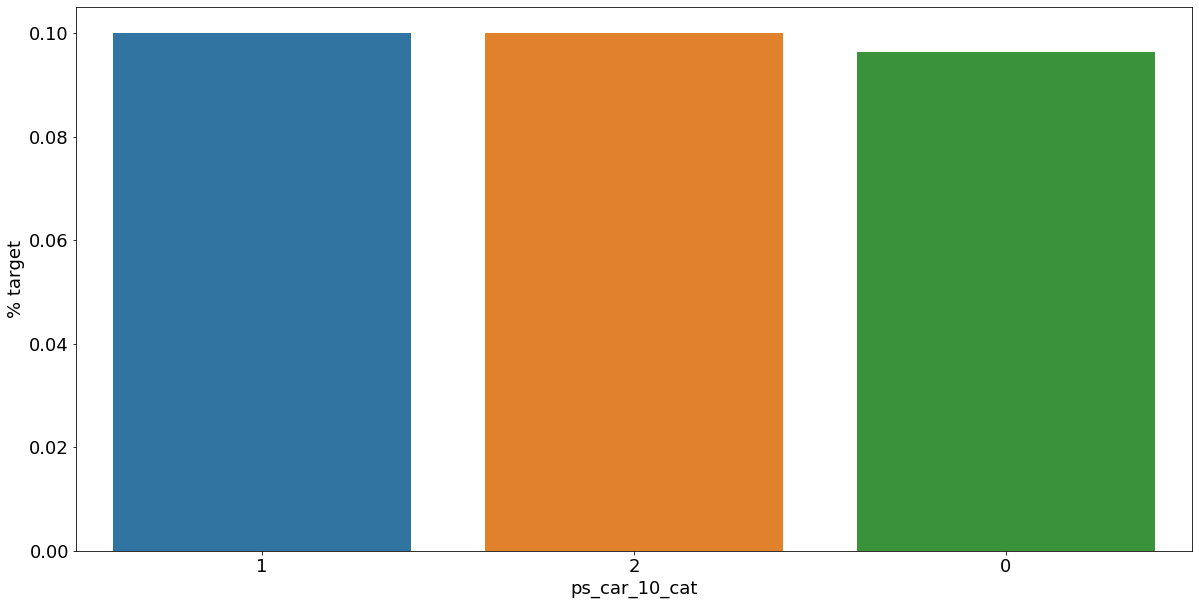

In [0]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10)) # figure instance와 axis를 return
    # 각 category value 별 target=1 퍼센트를 계산 (traget 평균값 이용)
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True) # 내림차순 정렬
    # 바 그래프 출력
    # target 평균값의 내림차순으로 정렬하여 출력
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

Missing values를 가진 variables을 보면, missing values를 mode 값으로 대체하는 것보다 하나의 분리된 category value로 유지해 사용하는 것이 더 좋은 아이디어라는 것을 알 수 있습니다. 보다시피, missing value를 가진 대부분의 고객들이 더 보험청구를 할 가능성이 높기 때문입니다.

### Interval variables
Interval variables 사이의 상관관계를 확인해봅시다. Heatmap은 variables 사이의 상관관계를 시각화하기 좋은 방법입니다. 아래 코드는 [Michael Waskom의 코드](http://seaborn.pydata.org/examples/many_pairwise_correlations.html)를 기반으로 작성되었습니다.

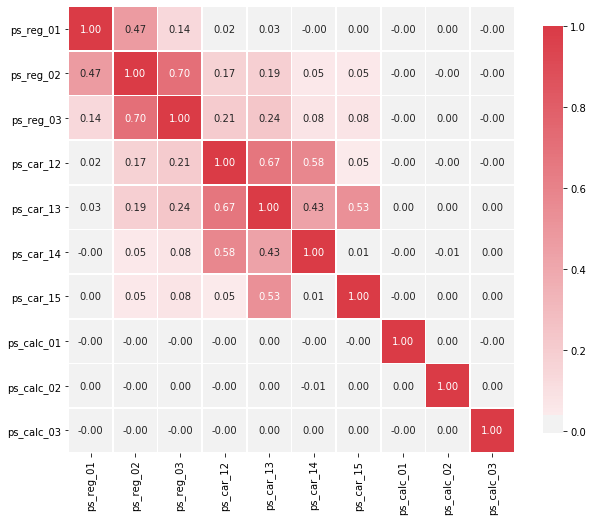

In [0]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # 2가지 색상 사이 범위로 color map을 생성
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

Variables 사이에 강한 상관관계가 존재합니다.
* ps_reg_02, ps_reg_03 (0.7)
* ps_car_12, ps_car13 (0.67)
* ps_car_12, ps_car14 (0.58)
* ps_car_13, ps_car15 (0.53)

Seaborn은 variables간에 관계를 시각화하는 여러 plot을 제공합니다. 그 중 pairplot을 사용해보도록 하겠습니다. 먼저 heatmap을 통해 모든 variables간에 관계를 전체적으로 보았으므로, 상관관계가 높게 나온 variables만 pairplot을 사용해 시각화 해보도록 하겠습니다.  
  
  
**참고**:프로세스 속도를 빠르게 하기 위해 트레이닝 데이터의 일부만 사용했습니다. 

In [0]:
s = train.sample(frac=0.1)

#### ps_reg_02, ps_reg_03
그래프를 보아 알 수 있듯이, 해당 variables간에는 선형적 관계가 존재합니다. hue 파리미터를 통해서 target=0과 target=1의 회귀선을 볼 수 있고, 비슷한 양상을 가진다는 것을 알 수 있습니다.

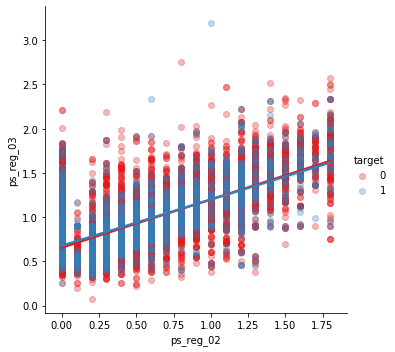

In [0]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

#### ps_car_12,  ps_car_13

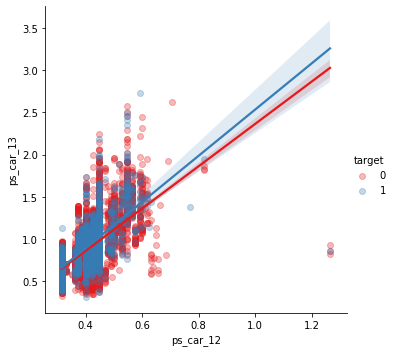

In [0]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

#### ps_car_12, ps_car_14

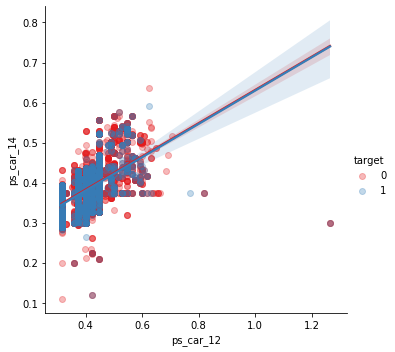

In [0]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

#### ps_car_13, ps_car_15

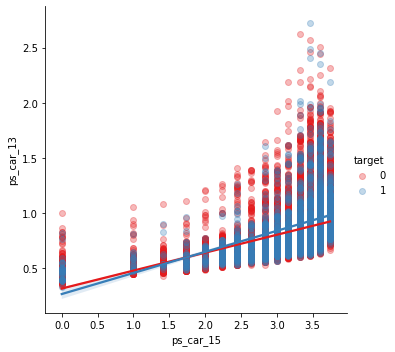

In [0]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

이렇게 시각화를 해보았습니다. 그러면 상관관계가 존재하는 variables 중에 어떤 것을 유지할지 어떻게 선택할까요? 여기서 우리는 데이터 차원을 감소시킬 수 있는  Principle Component Analysis (PCA)를 수행할 수 있습니다. PCA 관련해서는 [이 커널](https://www.kaggle.com/bertcarremans/reducing-number-of-numerical-features-with-pca)을 참조하시길 바랍니다.

### Ordinal variables 사이의 상관관계 확인하기

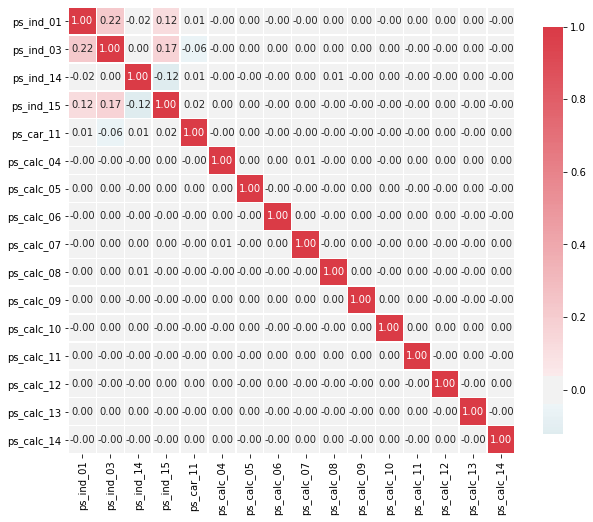

In [0]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

Ordinal variables 간에는 높은 상관관계가 존재하지 않는 것을 볼 수 있습니다.

<a class="anchor" id="feat_engineering"></a>

## Feature engineering

### dummy variables 만들기
Categorical variables의 값들은 특정한 순서 또는 크기로 표현될 수 없습니다. 예를 들어, category 2는  category 1 값의 2배를 의미하지 않습니다. 이를 수로 다루기 위해서, dummy variables를 만들 것입니다.  
첫번째 dummy variable은 나머지 dummy variables에서 의미를 표현해주고 있으므로 삭제할 것입니다.

In [0]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


결과적으로, 52개의 variables이 트레이닝 데이터셋에 추가되었습니다.

### Interaction variables 만들기
트레이닝 데이터에 추가적인 interaction variables을 추가해보도록 하겠습니다. 여기서 *get_feature_names* 메서드를 통해 새로운 variables에 대해 column 이름들을 할당해줄 수 있습니다.

In [0]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v)) # 다항변환 데이터를 dataframe으로 생성
interactions.drop(v, axis=1, inplace=True)  # 기존 columns 삭제
# 트레이닝 데이터에 interaction variables 추가
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train


<a class="anchor" id="feat_selection"></a>

## Feature selection

### 분산 값이 작은 features 삭제


개인적으로, 저는 features를 유지할 수 있는 분류 알고리즘(classifier algorithm)을 선호합니다. 하지만, 해야만 하는 일이 있습니다. 바로, 분산 값이 작은 feature를 삭제하는 것입니다. 이는 Scikit learn에서 제공되는 **VarianceThreshold**를 통해 쉽게 다뤄볼 수 있습니다.  
해당 메서드의 default 설정으로는 분산 값이 0인 feature만 삭제됩니다. 이전 단계들에서 보았듯이 분산값이 0인 feature는 없기에 default로 사용하면 효과가 없을 것입니다. 고로, threshold를 0.01로 설정하고 수행하도록 하겠습니다.

In [0]:
selector = VarianceThreshold(threshold=.01)
# id와 target값을 제외한 트레이닝 데이터셋 사용
selector.fit(train.drop(['id', 'target'], axis=1))

f = np.vectorize(lambda x : not x) # boolean array에 사용되는 토글 함수(toggle function)

# selector.get_support()는 VarianceThreshold에서 유지될 features만 mask를 매김
v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


분산 값을 활용해 features를 선택한다면, 28개의 feature가 삭제 될 것입니다. 하지만 현재 데이터셋에서는 많은 feature를 가지고 있지 않으므로, 적용하지 않고 classifier가 선택하도록 둘 것입니다. 많은 feature를 가지고 있는 데이터 셋에서는 헤당 프로세스를 진행하므로써, feature을 줄일 수 있습니다.  
Scikit learn에서는 다른 [feature selection 메서드들](http://scikit-learn.org/stable/modules/feature_selection.html)을 지원합니다. 이 중 SelectFromModel는 classifier가 최적의 features를 선택하게 만듭니다. 아래 코드에서 Random Forest를 활용한 방법을 보여드리겠습니다.

### Random Forest와 SelectFromModel을 활용한 feature selection
여기서 우리는 random forest에서의 feature 중요도를 기반으로 feature selection 하는 것을 배워보도록 하겠습니다. Scikit learn의 SelectFromModel은 feature 중요도 정도를 의미하는 threshold를 수동적으로 정해주면 얼마나 많은 variables을 유지할지 결정지어줍니다. 여기서는 단순히 50%의 최적의 variables을 선택해보겠습니다. 
> 아래 코드는 [Sebastian Raschka의 Github 저장소](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch04/ch04.ipynb)로부터 인용되었습니다. 이 Github 저장소는 그가 작성한 *Python Machine Learning*의 예제 코드들을 담고 있습니다. 꼭 읽어보시길 바랍니다.

In [0]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))


 1) ps_car_11_cat_te               0.021169
 2) ps_car_13                      0.017330
 3) ps_car_13^2                    0.017245
 4) ps_car_12 ps_car_13            0.017215
 5) ps_car_13 ps_car_14            0.017117
 6) ps_reg_03 ps_car_13            0.017102
 7) ps_car_13 ps_car_15            0.016819
 8) ps_reg_01 ps_car_13            0.016747
 9) ps_reg_03 ps_car_14            0.016198
10) ps_reg_03 ps_car_12            0.015569
11) ps_reg_03 ps_car_15            0.015164
12) ps_car_14 ps_car_15            0.015118
13) ps_car_13 ps_calc_01           0.014797
14) ps_reg_02 ps_car_13            0.014692
15) ps_car_13 ps_calc_02           0.014686
16) ps_car_13 ps_calc_03           0.014667
17) ps_reg_01 ps_reg_03            0.014643
18) ps_reg_01 ps_car_14            0.014379
19) ps_reg_03^2                    0.014280
20) ps_reg_03                      0.014272
21) ps_reg_03 ps_calc_03           0.013811
22) ps_reg_03 ps_calc_02           0.013770
23) ps_reg_03 ps_calc_01        

SelectFromModel을 사용하여 prefit classifier와 feature 중요도의 임계값을 구할 수 있습니다. 여기서 get_support 메서드를 통해 트레이닝 데이터의 variable 수를 줄일 수 있습니다.


In [0]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])


Number of features before selection: 162
Number of features after selection: 81


In [0]:
train = train[selected_vars + ['target']]

<a class="anchor" id="feat_scaling"></a>

## Feature scaling
앞서 말씀드렸듯, 트레이닝 데이터에 standard scaling을 적용할 수 있습니다. 이는 몇몇 classifiers들이 더 잘 수행할 수 있도록 합니다.

In [0]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])

## Conclusion
이 노트북이 대회를 진행하는데 있어 도움이 되었길 바랍니다. Vote는 자유롭게 부탁드리며, 질문이 있을시 코멘트를 부탁드립니다.